<a href="https://colab.research.google.com/github/varchasvshri/DL_codes/blob/master/SingleImgDehaz_GMAC_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import glob
from tensorflow.keras.layers import *

In [12]:
! git clone "https://github.com/tusharsircar95/All-In-One-Image-Dehazing-Tensorflow/" #getting training NYU2 training data

fatal: destination path 'All-In-One-Image-Dehazing-Tensorflow' already exists and is not an empty directory.


In [0]:
def setup_data_paths(orig_img_path, hazy_img_path):
    original_imag_paths = glob.glob(orig_img_path+ "/*.jpg")
    n = len(original_imag_paths)
    random.shuffle(original_imag_paths)

    train_keys = original_imag_paths[:int(n*0.90)]
    val_keys = original_imag_paths[int(n*0.90):]

    split_dict = {}
    for key in train_keys:
        split_dict[key] = "train"
    for key in val_keys:
        split_dict[key] = "val"

    hazy_imag_paths = glob.glob(hazy_img_path+ "/*.jpg")
    
    train_data = []
    valid_data = []

    for path in hazy_imag_paths:
        label = path.split('/')[-1]
        orig_path = orig_img_path + "/" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
        if split_dict[orig_path] == "train":
            train_data.append([path,orig_path])
        else:
            valid_data.append([path,orig_path])
    return train_data, valid_data #train_data[i] -- [/hazyimage_indexed_whatever.jpg, /orig_img corresponding to the hazy image]

In [14]:
train_data, val_data = setup_data_paths("./All-In-One-Image-Dehazing-Tensorflow/data/orig_images", "./All-In-One-Image-Dehazing-Tensorflow/data/hazy_images")
print(train_data[0])

['./All-In-One-Image-Dehazing-Tensorflow/data/hazy_images/NYU2_928_7_3.jpg', './All-In-One-Image-Dehazing-Tensorflow/data/orig_images/NYU2_928.jpg']


In [0]:
def load_image(X):
    X = tf.io.read_file(X) #read a file
    X = tf.image.decode_jpeg(X, channels=3) #convert jpeg image to tensor, channel = 3 as colored image
    X = tf.image.resize(X,(224,224)) # accordimg to gman crop all images to 224x224 image
    X = X/255. #normalize the image for faster training
    return X

def show_image(X):
    x = np.asarray(X*255, dtype = np.int32) #convert tensor to numpy array then show the image
    plt.figure()
    plt.imshow(x)
    plt.show()

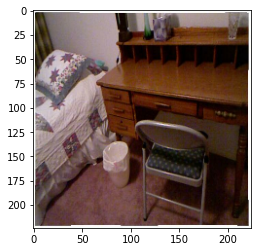

In [16]:
x = load_image(train_data[0][1])
show_image(x)

In [0]:
def create_datasets(train_data,val_data,batch_size):
  
  train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
  train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
  train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).batch(batch_size).shuffle(100).prefetch(batch_size * 4)

  val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
  val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
  val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).batch(batch_size).shuffle(100).prefetch(batch_size * 4)
  
#   iterator = tf.compat.v1.data.Iterator.from_structure(train_ds.output_types,train_ds.output_shapes)
  
#   train_init_op = iterator.make_initializer(train_ds)
#   val_init_op = iterator.make_initializer(val_ds)
  
#   return train_init_op, val_init_op, iterator
  return train_ds, val_ds

In [0]:
train_data, val_data = setup_data_paths("./All-In-One-Image-Dehazing-Tensorflow/data/orig_images", "./All-In-One-Image-Dehazing-Tensorflow/data/hazy_images")
train_init, val_init = create_datasets(train_data, val_data, 8)

In [0]:
def gman(X):
    x_r = X
    
    #### Two Convolutional layers ####
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)

    #### Two Downsampling layers ####
    x_r = Conv2D(filters = 128,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 128,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)

    ##### Residual Blocks ####
    x1 = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x1)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r) #non-activation layer
    x_r = tf.add(x1,x_r)
    x_r = tf.keras.activations.relu(x_r)

    x2 = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x2)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r) #non-activation layer
    x_r = tf.add(x2,x_r)
    x_r = tf.keras.activations.relu(x_r)

    x3 = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x3)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r) #non-activation layer
    x_r = tf.add(x3,x_r)
    x_r = tf.keras.activations.relu(x_r)

    x4 = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', activation='relu', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x4)
    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r) #non-activation layer
    x_r = tf.add(x4,x_r)
    x_r = tf.keras.activations.relu(x_r)
    ##### 4 residual blocks #####

    #### Two Deconvolutional layer ####
    x_r = Conv2DTranspose(filters=64, kernel_size=3, use_bias=False)(x_r)
    x_r = Conv2DTranspose(filters=64, kernel_size=3, use_bias=False)(x_r)

    x_r = Conv2D(filters = 64,kernel_size = 3, padding = 'same', use_bias = True, kernel_initializer=tf.initializers.random_normal(stddev=0.05))(x_r) #non-activation layer
    x_r = tf.add(x_r,X)
    x_r = tf.keras.activations.relu(x_r)
    
    return x_r

In [0]:
X = tf.compat.v1.placeholder(shape=(None,224,224,3), dtype = tf.float32)
Y = tf.placeholder(shape=(None,224,224,3), dtype = tf.float32)

dehazed_X = gman(X)

loss = tf.reduce_mean(tf.square(dehazed_X - Y))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
train = optimizer.minimize(loss)